In [2]:
# ECEN Data Mining Project – KMNIST end-to-end code

# 1. Data Preparation – Imports, reproducibility, device

import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

from torchvision.datasets import KMNIST
from torchvision import transforms

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
)

# Reproducibility and device
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)


Device: cuda


In [3]:
# 1. Data Preparation – Load KMNIST data (from NPZ if present, otherwise from torchvision)

def load_kmnist_npz_or_download():
    if (
        os.path.exists("kmnist-train-imgs.npz")
        and os.path.exists("kmnist-train-labels.npz")
        and os.path.exists("kmnist-test-imgs.npz")
        and os.path.exists("kmnist-test-labels.npz")
    ):
        train_imgs = np.load("kmnist-train-imgs.npz")["arr_0"]
        train_labels = np.load("kmnist-train-labels.npz")["arr_0"]
        test_imgs = np.load("kmnist-test-imgs.npz")["arr_0"]
        test_labels = np.load("kmnist-test-labels.npz")["arr_0"]
    else:
        transform = transforms.ToTensor()
        train_dataset = KMNIST(root="./data", train=True, download=True, transform=transform)
        test_dataset = KMNIST(root="./data", train=False, download=True, transform=transform)
        train_imgs = (train_dataset.data.numpy()).astype(np.uint8)
        train_labels = train_dataset.targets.numpy()
        test_imgs = (test_dataset.data.numpy()).astype(np.uint8)
        test_labels = test_dataset.targets.numpy()
        np.savez("kmnist-train-imgs.npz", arr_0=train_imgs)
        np.savez("kmnist-train-labels.npz", arr_0=train_labels)
        np.savez("kmnist-test-imgs.npz", arr_0=test_imgs)
        np.savez("kmnist-test-labels.npz", arr_0=test_labels)
    return train_imgs, train_labels, test_imgs, test_labels

train_imgs, train_labels, test_imgs, test_labels = load_kmnist_npz_or_download()

print("Train images:", train_imgs.shape)
print("Train labels:", train_labels.shape)
print("Test images:", test_imgs.shape)
print("Test labels:", test_labels.shape)


Train images: (60000, 28, 28)
Train labels: (60000,)
Test images: (10000, 28, 28)
Test labels: (10000,)


In [4]:
# 1. Data Preparation – Tensor conversion, train/val/test splits, scaling

# Tensor conversion
train_imgs_tensor = torch.tensor(train_imgs, dtype=torch.float32).unsqueeze(1) / 255.0
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_imgs_tensor = torch.tensor(test_imgs, dtype=torch.float32).unsqueeze(1) / 255.0
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Train/validation split
train_size = int(0.8 * len(train_imgs_tensor))
val_size = len(train_imgs_tensor) - train_size
train_dataset, val_dataset = random_split(
    TensorDataset(train_imgs_tensor, train_labels_tensor),
    [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED),
)

batch_size_default = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size_default, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size_default, shuffle=False)
test_loader = DataLoader(TensorDataset(test_imgs_tensor, test_labels_tensor),
                         batch_size=batch_size_default, shuffle=False)

# Flattened data for classical ML (baseline)
X_train_flat = train_imgs_tensor.view(len(train_imgs_tensor), -1).numpy()
X_val_flat = val_dataset.dataset.tensors[0][val_dataset.indices].view(len(val_dataset), -1).numpy()
X_test_flat = test_imgs_tensor.view(len(test_imgs_tensor), -1).numpy()

y_train = train_labels
y_val = train_labels[val_dataset.indices]
y_test = test_labels

scaler = StandardScaler()
X_train_flat = scaler.fit_transform(X_train_flat)
X_val_flat = scaler.transform(X_val_flat)
X_test_flat = scaler.transform(X_test_flat)

print("Data preparation done.")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")


Data preparation done.
Training samples: 48000
Validation samples: 12000
Test samples: 10000


In [5]:
# 1. Data Preparation – Tensor conversion, train/val/test splits, scaling

# Tensor conversion
train_imgs_tensor = torch.tensor(train_imgs, dtype=torch.float32).unsqueeze(1) / 255.0
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_imgs_tensor = torch.tensor(test_imgs, dtype=torch.float32).unsqueeze(1) / 255.0
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Train/validation split
train_size = int(0.8 * len(train_imgs_tensor))
val_size = len(train_imgs_tensor) - train_size
train_dataset, val_dataset = random_split(
    TensorDataset(train_imgs_tensor, train_labels_tensor),
    [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED),
)

batch_size_default = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size_default, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size_default, shuffle=False)
test_loader = DataLoader(TensorDataset(test_imgs_tensor, test_labels_tensor),
                         batch_size=batch_size_default, shuffle=False)

# Flattened data for classical ML (baseline)
X_train_flat = train_imgs_tensor.view(len(train_imgs_tensor), -1).numpy()
X_val_flat = val_dataset.dataset.tensors[0][val_dataset.indices].view(len(val_dataset), -1).numpy()
X_test_flat = test_imgs_tensor.view(len(test_imgs_tensor), -1).numpy()

y_train = train_labels
y_val = train_labels[val_dataset.indices]
y_test = test_labels

scaler = StandardScaler()
X_train_flat = scaler.fit_transform(X_train_flat)
X_val_flat = scaler.transform(X_val_flat)
X_test_flat = scaler.transform(X_test_flat)

print("Data preparation done.")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")


Data preparation done.
Training samples: 48000
Validation samples: 12000
Test samples: 10000



Class distribution in training set:
Class 0: 6000 samples
Class 1: 6000 samples
Class 2: 6000 samples
Class 3: 6000 samples
Class 4: 6000 samples
Class 5: 6000 samples
Class 6: 6000 samples
Class 7: 6000 samples
Class 8: 6000 samples
Class 9: 6000 samples


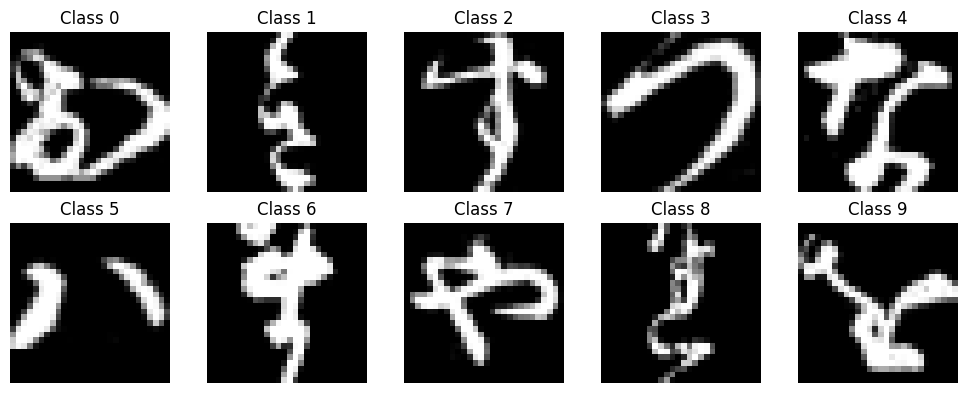

In [6]:
# 2. Exploratory Data Analysis – Descriptive statistics and sample images

unique, counts = np.unique(train_labels, return_counts=True)
print("\nClass distribution in training set:")
for u, c in zip(unique, counts):
    print(f"Class {u}: {c} samples")

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i in range(10):
    idx = np.where(train_labels == i)[0][0]
    axes[i // 5, i % 5].imshow(train_imgs[idx], cmap="gray")
    axes[i // 5, i % 5].set_title(f"Class {i}")
    axes[i // 5, i % 5].axis("off")
plt.tight_layout()
plt.show()


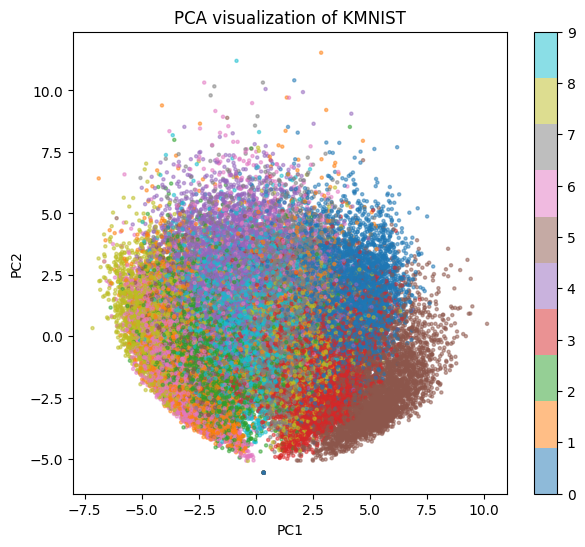

In [7]:
# 2. Exploratory Data Analysis – Dimensionality reduction (PCA)

from sklearn.decomposition import PCA

train_imgs_flat_for_pca = train_imgs.reshape(train_imgs.shape[0], -1) / 255.0
pca = PCA(n_components=2, random_state=SEED)
train_pca = pca.fit_transform(train_imgs_flat_for_pca)

plt.figure(figsize=(7, 6))
scatter = plt.scatter(train_pca[:, 0], train_pca[:, 1],
                      c=train_labels, cmap="tab10", alpha=0.5, s=5)
plt.colorbar(scatter)
plt.title("PCA visualization of KMNIST")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()



Logistic Regression baseline:
Accuracy: 0.6056


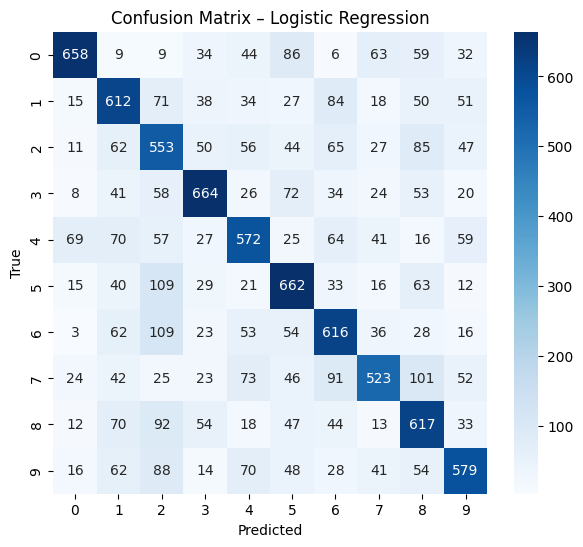

In [8]:
# 3. Model Selection – Baseline model: Logistic Regression

idx_subset = np.random.choice(len(X_train_flat), 10000, replace=False)
X_train_lr = X_train_flat[idx_subset]
y_train_lr = y_train[idx_subset]
logreg = LogisticRegression(max_iter=1000, n_jobs=-1)
logreg.fit(X_train_lr, y_train_lr)
y_test_pred_lr = logreg.predict(X_test_flat)

lr_acc = accuracy_score(y_test, y_test_pred_lr)
lr_prec = precision_score(y_test, y_test_pred_lr, average="weighted")
lr_rec = recall_score(y_test, y_test_pred_lr, average="weighted")
lr_f1 = f1_score(y_test, y_test_pred_lr, average="weighted")

print("\nLogistic Regression baseline:")
print("Accuracy:", lr_acc)

cm_lr = confusion_matrix(y_test, y_test_pred_lr)
plt.figure(figsize=(7, 6))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix – Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [9]:
# 3. Model Selection – CNN architectures

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.relu = nn.ReLU()
        if in_channels != out_channels:
            self.adjust = nn.Conv2d(in_channels, out_channels, 1)
        else:
            self.adjust = None

    def forward(self, x):
        identity = x
        out = self.relu(self.conv1(x))
        out = self.conv2(out)
        if self.adjust is not None:
            identity = self.adjust(identity)
        out += identity
        return self.relu(out)


class ResNetSimple(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = ResidualBlock(1, 32)
        self.pool = nn.MaxPool2d(2, 2)
        self.block2 = ResidualBlock(32, 64)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.block1(x)
        x = self.pool(x)
        x = self.block2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


class ImprovedCNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        if in_channels != out_channels:
            self.res_conv = nn.Conv2d(in_channels, out_channels, 1)
        else:
            self.res_conv = None

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.res_conv is not None:
            identity = self.res_conv(identity)
        out += identity
        return self.relu(out)


class ImprovedCNN(nn.Module):
    def __init__(self, dropout_rate=0.4):
        super().__init__()
        self.block1 = ImprovedCNNBlock(1, 32)
        self.pool = nn.MaxPool2d(2, 2)
        self.block2 = ImprovedCNNBlock(32, 64)
        self.block3 = ImprovedCNNBlock(64, 128)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(128 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.block1(x)
        x = self.pool(x)
        x = self.block2(x)
        x = self.pool(x)
        x = self.block3(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


class TunedImprovedCNN(ImprovedCNN):
    def __init__(self, dropout_rate=0.4):
        super().__init__(dropout_rate=dropout_rate)


In [10]:
# 3. Model Selection – Training and evaluation helper functions

def train_model(model, train_loader, val_loader, device, epochs=5, lr=1e-3):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    best_val_loss = float("inf")
    best_state = None

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
        val_loss /= len(val_loader.dataset)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = model.state_dict()

    if best_state is not None:
        model.load_state_dict(best_state)
    return model


def eval_model(model, loader, device, name="Dataset", show_cm=True):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average="weighted")
    rec = recall_score(all_labels, all_preds, average="weighted")
    f1 = f1_score(all_labels, all_preds, average="weighted")

    print(f"\n{name} classification report:")
    print(classification_report(all_labels, all_preds))

    if show_cm:
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(7, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(f"{name} Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

    return acc, prec, rec, f1, np.array(all_labels), np.array(all_preds)



Training Simple CNN
Epoch 1/5, Train Loss: 0.2962, Val Loss: 0.1282
Epoch 2/5, Train Loss: 0.0809, Val Loss: 0.0887
Epoch 3/5, Train Loss: 0.0403, Val Loss: 0.0904
Epoch 4/5, Train Loss: 0.0221, Val Loss: 0.1047
Epoch 5/5, Train Loss: 0.0157, Val Loss: 0.1003

Simple CNN – Test classification report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1000
           1       0.95      0.94      0.94      1000
           2       0.89      0.91      0.90      1000
           3       0.93      0.97      0.95      1000
           4       0.95      0.89      0.92      1000
           5       0.94      0.93      0.94      1000
           6       0.88      0.98      0.93      1000
           7       0.98      0.91      0.95      1000
           8       0.93      0.95      0.94      1000
           9       0.96      0.93      0.95      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94    

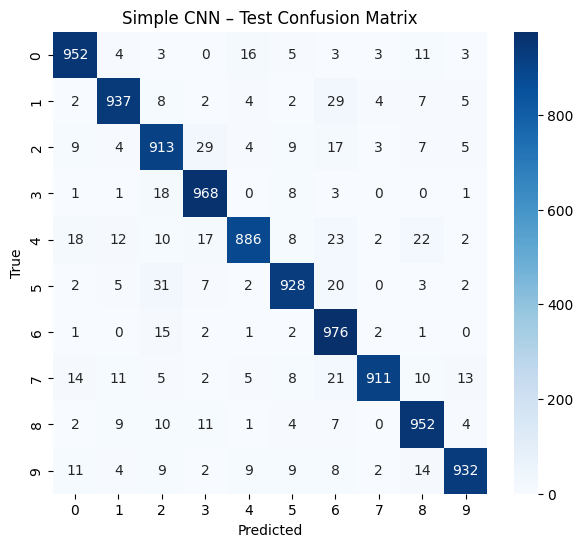

Simple CNN test accuracy: 0.9355


In [11]:
# 3. Model Selection – Train and evaluate Simple CNN

simple_cnn = SimpleCNN()
print("\nTraining Simple CNN")
simple_cnn = train_model(simple_cnn, train_loader, val_loader, DEVICE, epochs=5, lr=1e-3)
acc_sc, prec_sc, rec_sc, f1_sc, y_true_sc, y_pred_sc = eval_model(
    simple_cnn, test_loader, DEVICE, name="Simple CNN – Test"
)
print("Simple CNN test accuracy:", acc_sc)


Training ResNet-like CNN
Epoch 1/10, Train Loss: 0.3136, Val Loss: 0.1283
Epoch 2/10, Train Loss: 0.0819, Val Loss: 0.0960
Epoch 3/10, Train Loss: 0.0413, Val Loss: 0.1048
Epoch 4/10, Train Loss: 0.0260, Val Loss: 0.0923
Epoch 5/10, Train Loss: 0.0192, Val Loss: 0.1074
Epoch 6/10, Train Loss: 0.0147, Val Loss: 0.1085
Epoch 7/10, Train Loss: 0.0120, Val Loss: 0.0909
Epoch 8/10, Train Loss: 0.0091, Val Loss: 0.1119
Epoch 9/10, Train Loss: 0.0102, Val Loss: 0.0986
Epoch 10/10, Train Loss: 0.0088, Val Loss: 0.1345

ResNet-like CNN – Test classification report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1000
           1       0.93      0.93      0.93      1000
           2       0.93      0.91      0.92      1000
           3       0.98      0.96      0.97      1000
           4       0.84      0.96      0.90      1000
           5       0.98      0.91      0.94      1000
           6       0.92      0.97      0.94      1000
   

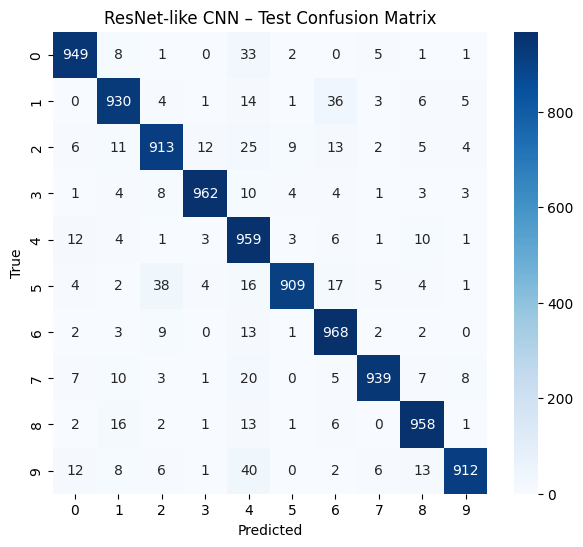

ResNet-like CNN test accuracy: 0.9399


In [12]:
# 3. Model Selection – Train and evaluate ResNet-like CNN

resnet_model = ResNetSimple()
print("\nTraining ResNet-like CNN")
resnet_model = train_model(resnet_model, train_loader, val_loader, DEVICE, epochs=10, lr=1e-3)
acc_res, prec_res, rec_res, f1_res, y_true_res, y_pred_res = eval_model(
    resnet_model, test_loader, DEVICE, name="ResNet-like CNN – Test"
)
print("ResNet-like CNN test accuracy:", acc_res)


Training Improved CNN
Epoch 1/10, Train Loss: 0.1937, Val Loss: 0.0869
Epoch 2/10, Train Loss: 0.0570, Val Loss: 0.0418
Epoch 3/10, Train Loss: 0.0384, Val Loss: 0.0509
Epoch 4/10, Train Loss: 0.0268, Val Loss: 0.0477
Epoch 5/10, Train Loss: 0.0221, Val Loss: 0.0299
Epoch 6/10, Train Loss: 0.0225, Val Loss: 0.0318
Epoch 7/10, Train Loss: 0.0168, Val Loss: 0.0380
Epoch 8/10, Train Loss: 0.0135, Val Loss: 0.0370
Epoch 9/10, Train Loss: 0.0107, Val Loss: 0.0379
Epoch 10/10, Train Loss: 0.0130, Val Loss: 0.0358

Improved CNN – Test classification report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1000
           1       0.99      0.94      0.97      1000
           2       0.97      0.89      0.93      1000
           3       0.93      0.99      0.96      1000
           4       0.96      0.94      0.95      1000
           5       0.97      0.96      0.97      1000
           6       0.94      0.97      0.96      1000
         

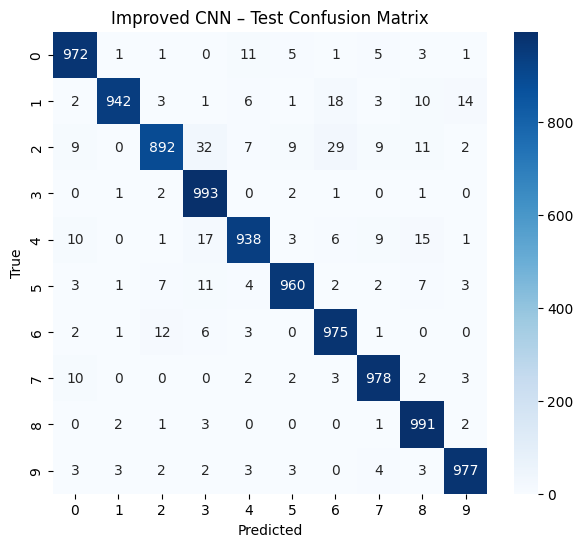

Improved CNN test accuracy: 0.9618


In [13]:
# 3. Model Selection – Train and evaluate base Improved CNN

improved_model = ImprovedCNN(dropout_rate=0.4)
print("\nTraining Improved CNN")
improved_model = train_model(improved_model, train_loader, val_loader, DEVICE, epochs=10, lr=1e-3)
acc_imp, prec_imp, rec_imp, f1_imp, y_true_imp, y_pred_imp = eval_model(
    improved_model, test_loader, DEVICE, name="Improved CNN – Test"
)
print("Improved CNN test accuracy:", acc_imp)


In [14]:
# 3. Model Selection – Hyperparameter tuning for TunedImprovedCNN

learning_rates = [0.001, 0.0005]
dropout_rates = [0.3, 0.4, 0.5]
batch_sizes = [64, 128]

best_val_acc = 0.0
best_params = None

print("\nHyperparameter search for TunedImprovedCNN")

for lr in learning_rates:
    for dr in dropout_rates:
        for bs in batch_sizes:
            print(f"\nlr={lr}, dropout={dr}, batch_size={bs}")
            train_loader_hp = DataLoader(train_dataset, batch_size=bs, shuffle=True)
            val_loader_hp = DataLoader(val_dataset, batch_size=bs, shuffle=False)

            model_hp = TunedImprovedCNN(dropout_rate=dr)
            model_hp = train_model(model_hp, train_loader_hp, val_loader_hp, DEVICE, epochs=3, lr=lr)

            model_hp.eval()
            all_preds = []
            all_labels = []
            with torch.no_grad():
                for images, labels in val_loader_hp:
                    images, labels = images.to(DEVICE), labels.to(DEVICE)
                    outputs = model_hp(images)
                    preds = torch.argmax(outputs, dim=1)
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
            val_acc = accuracy_score(all_labels, all_preds)
            print(f"Validation accuracy: {val_acc:.4f}")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_params = (lr, dr, bs)

print("\nBest hyperparameters:", best_params, "with val acc", best_val_acc)

best_lr, best_dropout, best_batch_size = best_params



Hyperparameter search for TunedImprovedCNN

lr=0.001, dropout=0.3, batch_size=64
Epoch 1/3, Train Loss: 0.1798, Val Loss: 0.0589
Epoch 2/3, Train Loss: 0.0520, Val Loss: 0.0424
Epoch 3/3, Train Loss: 0.0352, Val Loss: 0.0383
Validation accuracy: 0.9877

lr=0.001, dropout=0.3, batch_size=128
Epoch 1/3, Train Loss: 0.2011, Val Loss: 0.0707
Epoch 2/3, Train Loss: 0.0538, Val Loss: 0.0465
Epoch 3/3, Train Loss: 0.0315, Val Loss: 0.0553
Validation accuracy: 0.9837

lr=0.001, dropout=0.4, batch_size=64
Epoch 1/3, Train Loss: 0.2017, Val Loss: 0.0620
Epoch 2/3, Train Loss: 0.0575, Val Loss: 0.0516
Epoch 3/3, Train Loss: 0.0392, Val Loss: 0.0506
Validation accuracy: 0.9837

lr=0.001, dropout=0.4, batch_size=128
Epoch 1/3, Train Loss: 0.2414, Val Loss: 0.0910
Epoch 2/3, Train Loss: 0.0604, Val Loss: 0.0516
Epoch 3/3, Train Loss: 0.0397, Val Loss: 0.0361
Validation accuracy: 0.9879

lr=0.001, dropout=0.5, batch_size=64
Epoch 1/3, Train Loss: 0.2251, Val Loss: 0.0655
Epoch 2/3, Train Loss: 0.069


Training final TunedImprovedCNN
Epoch 1/10, Train Loss: 0.2808, Val Loss: 0.0621
Best model updated.
Epoch 2/10, Train Loss: 0.0741, Val Loss: 0.0525
Best model updated.
Epoch 3/10, Train Loss: 0.0457, Val Loss: 0.0561
Epoch 4/10, Train Loss: 0.0360, Val Loss: 0.0430
Best model updated.
Epoch 5/10, Train Loss: 0.0258, Val Loss: 0.0381
Best model updated.
Epoch 6/10, Train Loss: 0.0201, Val Loss: 0.0399
Epoch 7/10, Train Loss: 0.0179, Val Loss: 0.0407
Epoch 8/10, Train Loss: 0.0152, Val Loss: 0.0332
Best model updated.
Epoch 9/10, Train Loss: 0.0122, Val Loss: 0.0333
Epoch 10/10, Train Loss: 0.0124, Val Loss: 0.0296
Best model updated.

Tuned Improved CNN – Train classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4807
           1       1.00      1.00      1.00      4791
           2       1.00      1.00      1.00      4814
           3       1.00      1.00      1.00      4750
           4       1.00      1.00 

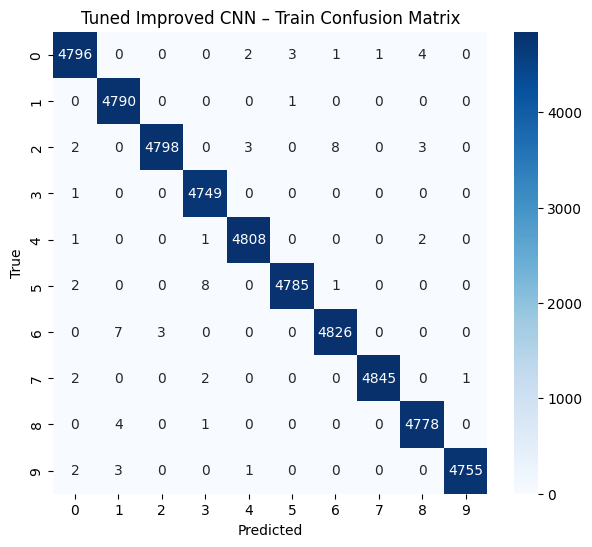


Tuned Improved CNN – Test classification report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1000
           1       0.98      0.97      0.97      1000
           2       0.98      0.93      0.95      1000
           3       0.97      0.99      0.98      1000
           4       0.95      0.96      0.96      1000
           5       0.98      0.97      0.97      1000
           6       0.95      0.99      0.97      1000
           7       0.98      0.99      0.98      1000
           8       0.97      0.99      0.98      1000
           9       0.99      0.97      0.98      1000

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



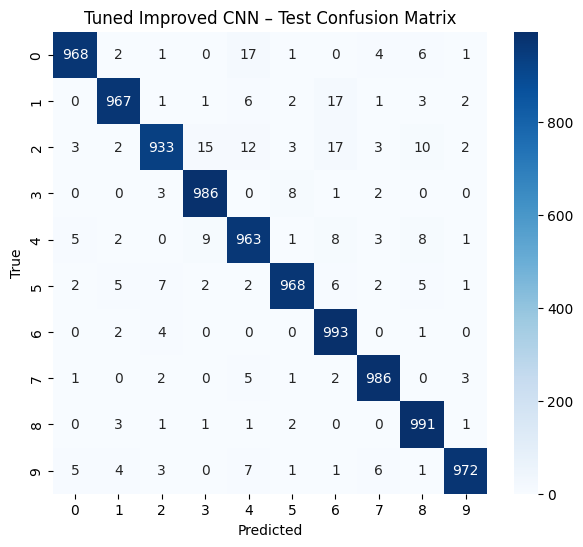

Final TunedImprovedCNN train accuracy: 0.9985416666666667
Final TunedImprovedCNN test accuracy: 0.9727


In [15]:
# 3. Model Selection – Final training and evaluation of TunedImprovedCNN

train_loader_best = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
val_loader_best = DataLoader(val_dataset, batch_size=best_batch_size, shuffle=False)
test_loader_best = DataLoader(TensorDataset(test_imgs_tensor, test_labels_tensor),
                              batch_size=best_batch_size, shuffle=False)

final_model = TunedImprovedCNN(dropout_rate=best_dropout)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(final_model.parameters(), lr=best_lr)
final_model.to(DEVICE)

best_val_loss = float("inf")
best_state = None

print("\nTraining final TunedImprovedCNN")

for epoch in range(10):
    final_model.train()
    running_loss = 0.0
    for images, labels in train_loader_best:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = final_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    train_loss = running_loss / len(train_loader_best.dataset)

    final_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader_best:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = final_model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
    val_loss /= len(val_loader_best.dataset)

    print(f"Epoch {epoch+1}/10, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_state = final_model.state_dict()
        torch.save(best_state, "best_tuned_improved_cnn.pth")
        print("Best model updated.")

if best_state is not None:
    final_model.load_state_dict(best_state)

acc_train_final, prec_train_final, rec_train_final, f1_train_final, y_true_train_final, y_pred_train_final = eval_model(
    final_model, train_loader_best, DEVICE, name="Tuned Improved CNN – Train"
)
acc_test_final, prec_test_final, rec_test_final, f1_test_final, y_true_test_final, y_pred_test_final = eval_model(
    final_model, test_loader_best, DEVICE, name="Tuned Improved CNN – Test"
)

print("Final TunedImprovedCNN train accuracy:", acc_train_final)
print("Final TunedImprovedCNN test accuracy:", acc_test_final)


Misclassified examples for TunedImprovedCNN:


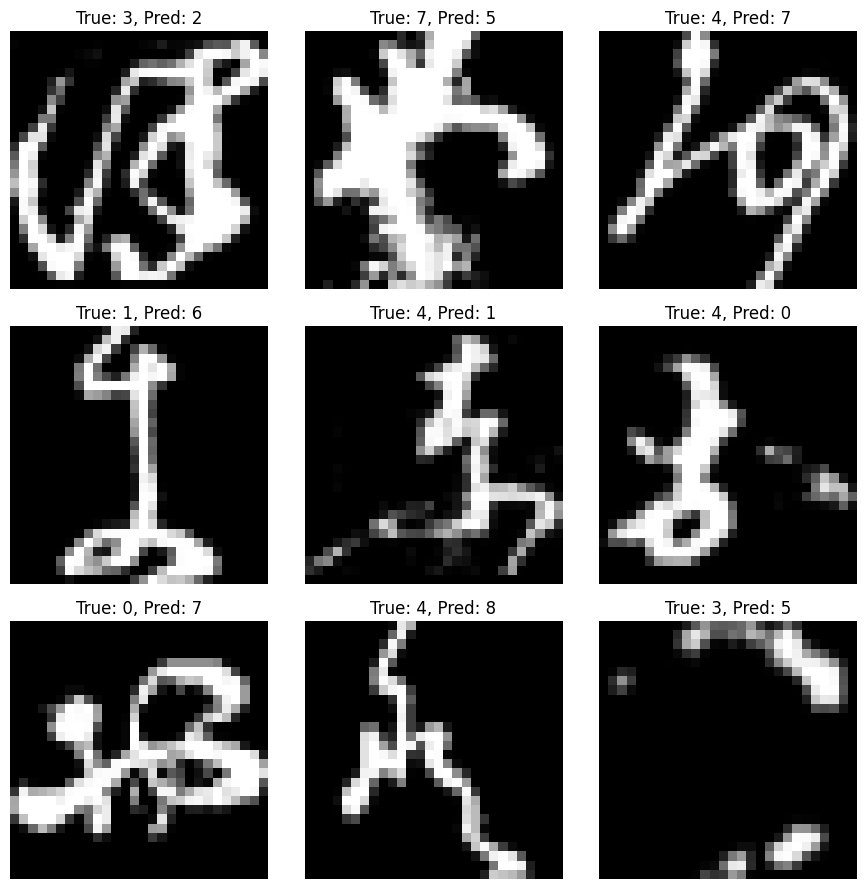

In [16]:
# Interpretability – show some misclassified test examples for TunedImprovedCNN

def plot_misclassified_examples(model, loader, device, n=9):
    model.eval()
    images_list = []
    true_list = []
    pred_list = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            mism = preds != labels
            if mism.any():
                for img, t, p, m in zip(images, labels, preds, mism):
                    if m.item():
                        images_list.append(img.cpu().squeeze().numpy())
                        true_list.append(t.item())
                        pred_list.append(p.item())
                        if len(images_list) >= n:
                            break
            if len(images_list) >= n:
                break

    rows = int(np.ceil(n / 3))
    fig, axes = plt.subplots(rows, 3, figsize=(9, 3 * rows))
    axes = axes.flatten()
    for i in range(n):
        axes[i].imshow(images_list[i], cmap="gray")
        axes[i].set_title(f"True: {true_list[i]}, Pred: {pred_list[i]}")
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

print("\nMisclassified examples for TunedImprovedCNN:")
plot_misclassified_examples(final_model, test_loader_best, DEVICE, n=9)

In [17]:
# 3. Model Selection – Aggregated metrics / model comparison

metrics = [
    {"Model": "Logistic Regression", "Accuracy": lr_acc, "Precision": lr_prec,
     "Recall": lr_rec, "F1-score": lr_f1},
    {"Model": "Simple CNN", "Accuracy": acc_sc, "Precision": prec_sc,
     "Recall": rec_sc, "F1-score": f1_sc},
    {"Model": "ResNet-like CNN", "Accuracy": acc_res, "Precision": prec_res,
     "Recall": rec_res, "F1-score": f1_res},
    {"Model": "Improved CNN", "Accuracy": acc_imp, "Precision": prec_imp,
     "Recall": rec_imp, "F1-score": f1_imp},
    {"Model": "Tuned Improved CNN", "Accuracy": acc_test_final, "Precision": prec_test_final,
     "Recall": rec_test_final, "F1-score": f1_test_final},
]

metrics_df = pd.DataFrame(metrics).sort_values(by="Accuracy", ascending=False)
print("\nModel comparison:")
print(metrics_df)


Model comparison:
                 Model  Accuracy  Precision  Recall  F1-score
4   Tuned Improved CNN    0.9727   0.972924  0.9727  0.972668
3         Improved CNN    0.9618   0.962318  0.9618  0.961645
2      ResNet-like CNN    0.9399   0.942118  0.9399  0.940263
1           Simple CNN    0.9355   0.936814  0.9355  0.935548
0  Logistic Regression    0.6056   0.613907  0.6056  0.607387
